In [1]:
import torch

import torch.nn as nn

import math
# torch变量封装函数Variable
from torch.autograd import Variable

# 定义Embeddings类实现文本嵌入层，这里s说明代表两个一摸一样的嵌入层，他们共享参数
# 该类继承nn.Module，这样就有标准层的一些功能
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        d_model: 词嵌入维度
        vocab: 词表大小
        """
        super(Embeddings, self).__init__()
        # 获得一个词嵌入对象lut
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # 将x传给self.lut并与根号下self.d_model相乘作为结果返回
        return self.lut(x) * math.sqrt(self.d_model)



In [2]:
# 词嵌入维度是512维
d_model = 512
# 词表大小是1000
vocab = 1000

x = Variable(torch.LongTensor([[100,2,421,508], [491,998,1,221]]))

In [4]:
emb = Embeddings(d_model, vocab)
embr = emb(x)
print(f'emb:{embr.shape}')

emb:torch.Size([2, 4, 512])


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        """
        max_len:每个句子最大长度
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # 初始化一个位置编码矩阵
        pe = torch.zeros(max_len, d_model)

        # 初始化一个绝对位置矩阵，索引表示
        position = torch.arange(0, max_len).unsqueeze(1)

        # 绝对位置矩阵初始化后，位置信息需要加入。
        # 最简单的思路就是将max_len * 1的绝对位置矩阵，变成max_len * d_model形状，然后覆盖原来的初始位置矩阵。

        div_term = torch.exp(torch.arange(0, d_model, 2)* -(math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # pe是二维矩阵，为了和embedding输出相加（三维），需要增加一个维度
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        forward函数的参数是x，表示文本序列的词嵌入表示
        """
        # 在相加前，对pe做一些适配工作，将这个三维张量的第二维，句子最大的那一维将切片到与输入x的第二维度相同，即，x.size(1)
        # 默认max_len=5000一般很大，需要进行与输入张量的适配
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

        return self.dropout(x)

In [6]:
d_model = 512
dropout = 0.1
max_len = 60
x = embr
print(f'x.shape is {x.shape}')

x.shape is torch.Size([2, 4, 512])


In [7]:
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)
print(f'pe_result shape is: {pe_result.shape}')

pe_result shape is: torch.Size([2, 4, 512])


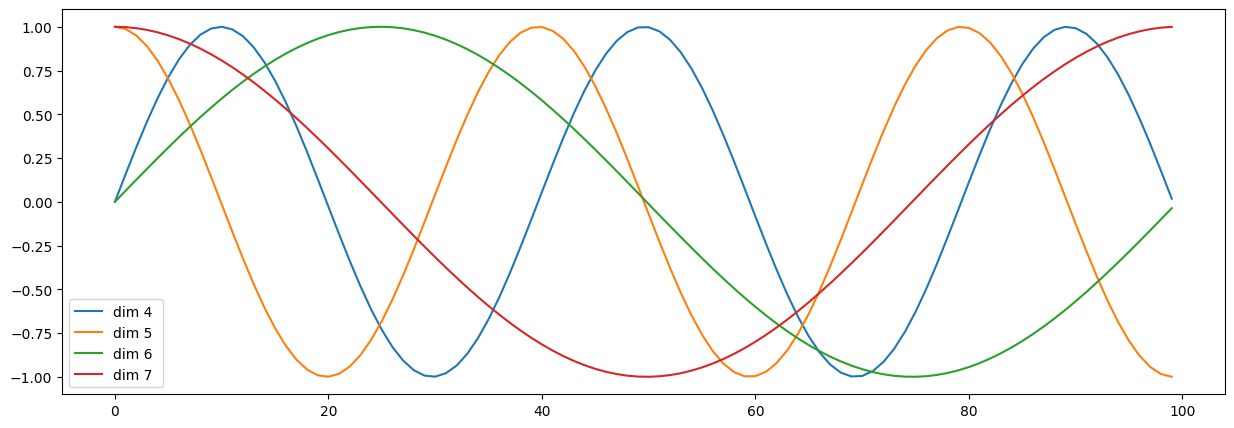

In [8]:
# 可视化
import matplotlib.pyplot as plt
import numpy as np

# 创建一张15*5大小的画布
plt.figure(figsize=(15,5))
pe = PositionalEncoding(20,0)

# 输入0，被处理后相当于位置编码张量
y = pe(Variable(torch.zeros(1,100,20)))

plt.plot(np.arange(100), y[0,:,4:8].data.numpy())

plt.legend(["dim %d "%p for p in [4,5,6,7]])

In [9]:
def subsequent_mask(size):
    """
    生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，最后两维形成一个方阵
    """
    # 首先定义掩码张量形状
    attn_shape = (1, size, size)

    # 然后像这个形状中添加1，形成上三角矩阵，最后为了节约空间，再使其中的数据类型变为无符号8位整形unit8
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    # 最后将numpy类型转化为torch中的tensor，内部做一个1-的操作
    # 实际相当于三角矩阵的反转
    return torch.from_numpy(1 - subsequent_mask)

In [10]:
np.triu([[1,2,3], [4,5,6], [7,8,9], [10,11,12]], k=-1)
np.triu([[1,2,3], [4,5,6], [7,8,9], [10,11,12]], k=0)
np.triu([[1,2,3], [4,5,6], [7,8,9], [10,11,12]], k=1)

array([[0, 2, 3],
       [0, 0, 6],
       [0, 0, 0],
       [0, 0, 0]])

In [12]:
# input
size = 5

sm = subsequent_mask(size)
print(f'sm shape is: {sm.shape}')

sm shape is: torch.Size([1, 5, 5])


注意力机制的计算：\
$Q: query$\
$K: Key$\
$V: Value$\
$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$

In [13]:
import torch
import math
import torch.nn.functional as F

def attention(query, key, value, mask=None, dropout=None):

    # 首先取query的最后一维的大小，一般情况下就等同于词嵌入维度，命名为d_k
    d_k = query.size(-1)
    # 根据注意力公式，将query与key的转置相乘，这里key是最后两个维度转置，再除以缩放系数
    scores = torch.matmul(query, key.transpose(-2,-1))/math.sqrt(d_k)

    # 判断是否使用掩码张量
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # 对scores的最后一维进行softmax操作，使用F.softmax方法
    # 这样最终获得注意力张量
    p_attn = F.softmax(scores, dim=-1)

    # 之后判断是否使用dropout进行随机置0
    if dropout is not None:
        # 将p_attn传入
        p_attn = dropout(p_attn)
    
    # 最后，根据公式将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn
    

In [14]:
input = Variable(torch.randn(5,5))
input

tensor([[-1.1948,  0.2455, -0.8105, -1.3322,  0.0044],
        [ 0.9032,  1.0557,  0.6225,  0.7697,  0.4002],
        [ 0.7741, -0.2852,  0.7596,  0.4772, -0.8080],
        [ 0.4406, -0.6418,  0.9423, -0.3167, -1.5067],
        [ 0.5119,  0.2482,  0.5457, -1.8462,  1.9936]])

In [15]:
mask = Variable(torch.zeros(5,5))
mask

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [16]:
input.masked_fill(mask == 0, -1e9)

tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])

In [18]:
pe_result.shape

torch.Size([2, 4, 512])

In [19]:
query = key = value = pe_result

In [21]:
# 调用
attn, p_attn = attention(query, key, value)
print(f'attn shape is: {attn.shape}')
print(f'p_attn shape is:{p_attn.shape}')

attn shape is: torch.Size([2, 4, 512])
p_attn shape is:torch.Size([2, 4, 4])


In [22]:
# 令mask为一个2*4*4的零张量
mask = Variable(torch.zeros(2,4,4))

In [23]:
# 调用
attn, p_attn = attention(query, key, value,mask=mask)
print(f'attn shape is: {attn.shape}')
print(f'p_attn shape is:{p_attn.shape}')

attn shape is: torch.Size([2, 4, 512])
p_attn shape is:torch.Size([2, 4, 4])


In [24]:
import copy

def clones(module, N):

    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 多头注意力机制类
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()

        assert embedding_dim % head == 0
        self.d_k = embedding_dim // head
        self.head = head
        # 克隆四个：Q、K、V和最后拼接矩阵
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        # 最后获得的注意力张量
        self.attn = None

        self.dropout = nn.Dropout(p=dropout)
    def forward(self, query, key, value, mask=None):
        # 是否存在掩码张量mask
        if mask is not mask:
            # 扩展维度，代表多头中的第n头
            mask = mask.unsqueeze(1)

        # 获得batch_size变量，它是query尺寸的第一个数字，代表样本数量
        batch_size = query.size(0)
        # 多头处理环节
        # zip将QKV与三个线性层组合一起，然后使用for循环，将QKV分别传到线性层中
        # 做完线性变化，为每个头分割输入，这里使用view方法对线性变化的结果维度重塑
        # 意味着每个开头可以获得一部分词特征组成的句子，其中-1代表自适应维度
        
        query, key, value = \
            [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1,2)
             for model, x in zip(self.linears, (query, key, value))]
        # 得到每个头的输入后，接下来将他们传入到attention中
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 重塑形状，变成和输入形状相同
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.head*self.d_k)
        
        return self.linears[-1](x)

In [25]:
x = torch.randn(1,2,3,4)
x.size()

torch.Size([1, 2, 3, 4])

In [26]:
y = x.view(1,3,2,4)
y.size()
z = x.transpose(1,2)
z.size()
print(f'y == z?:{torch.equal(y,z)}')

y == z?:False


In [28]:
# example
head = 8
embedding_dim = 512
dropout = 0.2

query = key = value = pe_result

mask = Variable(torch.zeros(8,4,4))

mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(f'mha_result.shape is {mha_result.shape}')


mha_result.shape is torch.Size([2, 4, 512])


In [29]:
# 前馈前连接层
class PositionweiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        d_model: 线性层输入维度
        d_ff: 第二个线性层维度
        """
        super(PositionweiseFeedForward, self).__init__()

        # 首先按照预期使用nn实例化了两个线性层对象，self.w1和self.w2
        # 它们的参数分别是d_model,d_ff和d_ff,d_model
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        首先经过第一个线性层，然后使用Funtional中的relu函数进行激活
        在使用dropout层进行随机置0，通过第二个线性层w2，返回最终结果。
        """
        return self.w2(self.dropout(F.relu(self.w1(x))))


In [30]:
d_model = 512
d_ff = 64
dropout = 0.2

x = mha_result
ff = PositionweiseFeedForward(d_model, d_ff,dropout)
ff_result = ff(x)
print(f'ff_result.shape is {ff_result.shape}')

ff_result.shape is torch.Size([2, 4, 512])


In [31]:
# 规范化层
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        """
        根据features的形状初始化两个参数张量a2和b2，
        对上一层得到的结果做规范化公式计算，改变正常表征
        """
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        self.eps = eps
    
    def forward(self, x):
        """
        对输入变量x再最后一个维度求均值，并保持输出维度与输入维度一致，
        接着求最后一个维度的标准差，根据规范化公式，用x减去均值除以标准差获得规范化结果
        最后乘以缩放系数
        """
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)

        return self.a2 * (x-mean) / (std + self.eps) + self.b2


In [32]:
features = d_model = 512
eps = 1e-6
x = ff_result
# 调用
ln = LayerNorm(features, eps)
ln_result = ln(x)
print(f'ln_result shape is{ln_result.shape}')

ln_result shape istorch.Size([2, 4, 512])


In [33]:
# 子层连接结构
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        super(SublayerConnection, self).__init__()
        # 实例化了规范化对象self.norm
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, sublayer):
        """
        前向传播中，接收上一个层或子层的输入作为第一个参数，将该子层连接中的子层函数作为第二个参数。
        首先对输出进行规范化，结果传给子层处理，之后在对子层采用dropout操作
        dropout的使用，最后还有一个add操作
        因为存在跳跃连接，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出
        """
        return x + self.dropout(sublayer(self.norm(x)))
        

In [34]:
size = 512
dropout = 0.2
head = 8
d_model = 512
# x为位置编码器的输出
x = pe_result
mask = Variable(torch.zeros(8,4,4))

# 假设子层中装的是多头注意力层，实例化这个类
self_attn = MultiHeadedAttention(head, d_model)

# 使用lambda获得一个函数类型的子层
sublayer = lambda x: self_attn(x, x, x, mask)
sc = SublayerConnection(size, dropout)
sc_result = sc(x, sublayer)
print(f'sc_result shape is {sc_result.shape}')

sc_result shape is torch.Size([2, 4, 512])


In [35]:
# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()

        # 首先将self_attn和self_forward传入其中
        self.self_attn = self_attn
        self.feed_forward = feed_forward

        # 编码器层有两个子层连接结构，所以使用clones函数进行clone
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):
        """
        x: 上一层输出
        mask: 掩码张量
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [36]:
# example
size = 512
head = 8
d_model = 512
d_ff = 64
x = pe_result
dropout = 0.2
self_attn = MultiHeadedAttention(head, d_model)
ff = PositionweiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(8,4,4))

el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)
print(f' el_result.shape is {el_result.shape}')


 el_result.shape is torch.Size([2, 4, 512])


In [37]:
# 使用Encoder类实现编码器
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()

        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    

In [38]:
# example 
size = 512
head = 8
d_model = 512
d_ff = 64
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionweiseFeedForward(d_model, d_ff, dropout)
dropout = 0.2
layer = EncoderLayer(size, c(attn), c(ff), dropout)

# N 为编码器层个数
N = 8
mask = Variable(torch.zeros(8,4,4))

In [39]:
en = Encoder(layer, N)
en_result = en(x, mask)
print(f'en_result.shape is {en_result.shape}')

en_result.shape is torch.Size([2, 4, 512])


In [40]:
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()

        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        # 按照结构图使用clones函数克隆三个子层连接对象
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, source_mask, target_mask):
        # memory为来自编码器层的语义存储变量

        m = memory

        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, source_mask))

        # 最后一个层就是前馈全连接子层，经过它的处理后就可以返回结果，这就是解码器层结构。
        return self.sublayer[2](x, self.feed_forward)

In [41]:
# example
head = 8
size = 512
d_model = 512
d_ff = 64
dropout = 0.2
self_attn = src_attn = MultiHeadedAttention(head, d_model, dropout)
ff = PositionweiseFeedForward(d_model, d_ff, dropout)
# x是来自目标数据的词嵌入表示，但形式和源数据的词嵌入表示相同，使用pe_r充当
x = pe_result

memory = en_result

mask = Variable(torch.zeros(8,4,4))
# 这里只是为了方便计算，实际src和tgt的mask不同
source_mask = target_mask = mask
# 调用
dl = DecoderLayer(size, self_attn, src_attn, ff, dropout)
dl_result = dl(x, memory, source_mask, target_mask)
print(f'dl_result.shape is {dl_result.shape}')

dl_result.shape is torch.Size([2, 4, 512])


In [42]:
# 解码器
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, source_mask, target_mask):
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

In [44]:
# example
size = 512
d_model = 512
head = 8
d_ff = 64
dropout = 0.2
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionweiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
N = 8
x = pe_result
memory = en_result
mask = Variable(torch.zeros(8,4,4))
source_mask = target_mask = mask
de = Decoder(layer, N)
de_result = de(x, memory, source_mask, target_mask)
print(f'de_result.shape is {de_result.shape}')

de_result.shape is torch.Size([2, 4, 512])


In [45]:
# 将线性层和softmax计算层一起实现，因为二者的共同目标是生成最后的结构，因此类的名字叫做Generator
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        # 首先就是使用nn中的预定义线性层实现实例化，得到一个对象self.project等待使用
        # 这个线性层的参数有两个，就是初始化函数进来的两个参数：d_model, vocab_size
        self.project = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        """
        首先使用上一次得到的self.project对x进行线性变化，然后使用F中已经实现的log_softmax进行softmax处理
        """
        return F.log_softmax(self.project(x), dim=-1)

In [46]:
m = nn.Linear(20,30)
input = Variable(torch.randn(128,20))
output = m(input)
print(output.size())
d_model = 512
vocab_size = 1000
x = de_result
gen = Generator(d_model, vocab_size)
gen_result = gen(x)
print(f'gen_result shape is {gen_result.shape}')

torch.Size([128, 30])
gen_result shape is torch.Size([2, 4, 1000])


In [47]:
# 使用EncoderDecoder实现编码器-解码器架构
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        """
        encoder：编码器对象
        decoder：解码器对象
        source_embed：源数据嵌入函数
        target_embed：目标数据嵌入函数
        generator：输出部分的类别生成器对象
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
        self.generator = generator
    
    def forward(self, source, target, source_mask, target_mask):
        """
        source：源数据
        target：目标数据
        source_mask：源掩码张量
        target_mask：目标掩码张量
        """
        return self.decode(self.encode(source, source_mask), source_mask, target, target_mask)
    
    def encode(self, source, source_mask):
        return self.encoder(self.src_embed(source), source_mask)
    
    def decode(self, memory, source_mask, target, target_mask):
        return self.decoder(self.tgt_embed(target), memory, source_mask, target_mask)

In [48]:
vocab_size = 1000
d_model = 512
encoder = en
decoder = de
source_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
generator = gen

source = target = Variable(torch.LongTensor([[100,2,421,500], [491,998,1,221]]))
source_mask = target_mask = Variable(torch.zeros(8,4,4))

# 调用
ed = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
ed_result = ed(source, target, source_mask, target_mask)
print(f'ed_result shape is {ed_result.shape}')


ed_result shape is torch.Size([2, 4, 512])


In [49]:
# Transformer模型构建
def make_model(source_vocab, target_vocab, N=6, d_model=512, d_ff=2048, head=8, dropout=0.1):
    """
    source_vocab：源数据特征（词汇）总数
    target_vocab：目标数据特征（词汇）总数
    N：堆叠数量
    d_model：词向量映射维度
    d_ff：前馈全连接网络中变换矩阵的维度
    head：多头注意力结构中的多头数
    dropout：置0率
    """
    c = copy.deepcopy
    # 实例化多注意力类，得到对象attn
    attn = MultiHeadedAttention(head, d_model)
    # 实例化前馈全连接类，得到对象ff
    ff = PositionweiseFeedForward(d_model, d_ff, dropout)
    # 实例化位置编码类，得到对象position
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, source_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, target_vocab), c(position)),
        Generator(d_model, target_vocab)
    )

    # 模型结构完成后，初始化模型中的参数，比如线性层中的变化矩阵
    # 这里判断参数维度大于1，那么将其初始化成一个服从均匀分布的矩阵
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model


In [50]:
# import torch
# import torch.nn as nn
# # nn.init.xavier_uniform演示
# w = torch.empty(3,5)
# w = nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
# w

In [52]:
source_vocab = 11
target_vocab = 11
N = 6
# 其他参数默认值

# 调用
if __name__ == '__main__':
    res = make_model(source_vocab, target_vocab, N)
    print(res)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionweiseFeedForward(
          (w1): Linear(in_features=512, out_features=2048, bias=True)
          (w2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-5): 6 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_f

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23008\3026352169.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)
